# Title: DeTeCtive: Detecting AI-generated Text via Multi-Level Contrastive Learning

#### Members' Names:
Derek Liu, Jenny Huang, Gary Kong

#### Emails:
derek.liu@torontomu.ca, ziying.huang@torontomu.ca, gary.kong@torontomu.ca

---
# Introduction:

#### Problem Description:

The rapid advancement of Generative AI (GenAI) poses significant challenges in identifying and distinguishing AI-generated text from human authored texts and attributing it accurately to specific AI models (or "authors").

#### Context of the Problem:

The development and growth of GenAI technologies has raised concerns on ethics, misinformation, academic integrity, content authenticity, and overall information security. Reliable and robust detection mechanisms are increasingly necessary in both academia and workplace to uphold integrity and accuracy in digital communications.

#### Limitation About other Approaches:

Current detection techniques primarily utilize manual feature crafting, supervised binary classification, or embedding filtering, resulting in performance bottlenecks and poor generalization, particularly when dealing with out-of-distribution (OOD) data or newly developed Large Language Models (LLMs). These methods often fail to account for nuanced stylistic variations in texts generated by different AI models, limiting their accuracy and adaptability.

#### Solution:

The **DeTeCtive** framework addresses these limitations by employing a multi-task and multi-level contrastive learning approach. Instead of traditional binary classification, **DeTeCtive** distinguishes nuanced writing styles across various AI models and human-generated texts through integrating a dense information retrieval pipeline with embeddings and a $k$-Nearest Neighbor (kNN) classifier to enhance detection performance. Furthermore, DeTeCtive includes a Training-Free Incremental Adaptation (TFIA) mechanism that allows seamless adaptation to OOD data without additional training, significantly enhancing its practical applicability and adaptability.

# Background

Below are the summary of the related works

| Reference | Explanation | Dataset/Input | Weakness
| --- | --- | --- | --- |
| Kuznetsov<br> et al. [1] | They removed domain-specific dimensions<br> in embeddings to detect AI-generated texts<br> using linear decomposition and subspace<br> selection. | Cross-domain text datasets<br> (e.g., Wikipedia, GPT-3.5<br> generations) | Limited flexibility and potential performance<br> issue when encountering texts generated by<br> models or domains significantly different<br> from training data.
| Kim et al. [2] | They used hierarchical discourse parsing<br> and analysis of rhetorical structures,<br> specifically focusing on structural and<br> stylistic linguistic cues. | Annotated datasets from<br> academic and news texts<br> with discourse annotations | Less effective on short, informal, or<br> structurally ambiguous texts.
| Guo et al. [3] | They combined a multi-task learning<br> framework combined with multi-level<br> contrastive learning and a k-Nearest<br> Neighbor ($k$NN) classifier to differentiate<br> stylistic nuances between various AI<br> models. | Standard AI-generated <br> (e.g., GPT-4 generations) | Eficiency may decrease with large-scale<br> databases.

---
# Methodology

The DeTeCtive method employs a comprehensive pipeline for embedding text, indexing embeddings, retrieving nearest neighbors, and evaluating model performance in identifying AI-generated text. This methodology involves several interconnected components outlined as follows:

#### Step 1: Data Preparation and Dataset Loading (`src/OUTFOX_utils.py`)
The source dataset, `OUTFOX` in this case, comprises of labelled human-generated and AI-generated passages (ChatGPT was used in the OUTFOX dataset). The `mix_train_data()` and `mix_test_data()` functions are used to prepare training and test datasets, mixing human and AI-generated samples and labeling accordingly.

#### Step 2: Dataset Handling (`src/dataset.py`)
The `PassagesDataset` class helps efficiently manages the loaded dataset. Each passage is appended with its corresponding label (human or AI-generated) and source metadata, enabling structured and streamlined retrieval during training and inference.

#### Step 3: Embedding Generation (`src/text_embedding.py`)
The script uses a pre-trained transformer-based model. In this case, it leverages the `RoBERTa` model. Passages are tokenized using an `AutoTokenizer` and encoded by an `AutoModel` to generate embeddings. A pooling strategy, `average_pooling` in this case, is applied to transform variable-length token sequences into fixed-size embeddings. Embeddings are subsequently normalized to facilitate accurate indexing and retrieval.

#### Step 4: Indexing and Retrieval (`src/index.py`)
The normalized embeddings are indexed using the `faiss` (Facebook AI Similarity Search) library. The `Indexer` class creates and manages a searchable index (`faiss.IndexFlatIP()`), allowing for efficient nearest neighbor searches, storing each embedding along with its corresponding identifier for retrieval.

This indexing system also supports TFIA, which newly generated embeddings can be added to the existing index without retraining the model. The index grows incrementally with each new batch of data, adapting to distributional shifts over time.

#### Step 5: $k$-Nearest Neighbors Classification ($k$NN) (`src/index.py`)
It then performs retrieval using $k$-Nearest Neighbor ($k$NN) search. For each test query embedding, the closest embeddings from the indexed training dataset are retrieved through the `search_knn()` function. Predictions are generated by majority voting among retrieved neighbors. Since the model does not rely on any trained classifier, this classification mechanism directly utilizes the similarity of embeddings, making it suitable for TFIA. Performance metrics—including accuracy, precision, recall, and F1 score—are calculated by comparing these predictions against ground-truth labels using the `calculate_metrics()` function in `src/utils.py`.

#### Step 6: Iterative Optimization and Visualization (`src/test_from_database.py`)
This pipeline can iteratively identify optimal parameters, such as the best value of $k$ for kNN classification. Performance across a range of $k$ values is systematically evaluated, visualized through plots (accuracy, precision, recall, and F1 score) to facilitate a clear understanding of model behavior and parameter optimization.

Since the model remains fixed and only the index is updated, TFIA enables adaptation to new data distributions (i.e., OOD data) without any gradient-based retraining or parameter updates.

![Alternate text](https://raw.githubusercontent.com/heyongxin233/DeTeCtive/refs/heads/main/fig/overall.png "Overview of DeTeCtive:
(a) Training: Firstly, a pre-trained text encoder is fine-tuned using multi-task, multi-level contrastive loss, enabling it to differentiate distinct writing styles effectively.
(b) Inference: Then similarity-based retrieval method is used for classification, enhanced by TFIA to effectively handle OOD texts.")
#### Figure 1: Overview of DeTeCtive
- Training: Firstly, a pre-trained text encoder is fine-tuned using multi-task, multi-level contrastive loss, enabling it to differentiate distinct writing styles effectively.
- Inference: Then, a similarity-based retrieval method is used for classification, enhanced by TFIA to effectively handle OOD texts.

---
# Implementation

Below we will show the codes that perform the following key tasks:
1. Embedding generation
2. $k$NN search and classification
3. Training-Free Incremental Adaptation (TFIA) mechanism

#### **1. Embedding generation**
(Location: Line 15-50 in `src/test_from_database.py`)

The embedding generation process converts raw text into numerical representations that capture writing style patterns. This is the foundation for distinguishing between human and AI-generated text.

**Key Features:**
- Uses `RoBERTa` to capture deep linguistic features
- Normalization enables accurate similarity comparisons
- Processes variable-length texts through padding/truncation

In [ ]:
def infer(passages_dataloader, fabric, tokenizer, model):
    # Tokenization and model forward pass
    encoded_batch = tokenizer(text,
                            return_tensors="pt",      # Convert text to PyTorch tensors
                            padding="max_length",     # Standardize input length
                            truncation=True)          # Handle long documents

    # Generate embeddings via RoBERTa
    embeddings = model(encoded_batch.to(device))       # Forward pass through model

    # L2 normalization for cosine similarity
    return embeddings / (torch.norm(embeddings) + 1e-6)

#### **2. $k$NN search and classification**
(Location: Line 120-150 in `src/test_from_database.py`)

The $k$-Nearest Neighbors ($k$NN) classifier compares new text embeddings against a database of known examples, using majority voting to determine the most likely source (human or specific AI model).


In [ ]:
# FAISS index setup for fast similarity search
index = faiss.IndexFlatIP(768)  # Optimized for cosine similarity
index.add(embeddings)           # Populate with training embeddings

# Query processing
distances, indices = index.search(query_emb, k=5)  # Top-5 nearest neighbors

# Majority vote classification
pred = 'AI' if sum(labels[indices]==0) > k//2 else 'Human'  # Majority vote

#### **3. TFIA mechanism**

(Location: Line 200-210 in `src/test_from_database.py`)

TFIA allows the system to incorporate new AI models without retraining, by simply adding their embeddings to the existing search database. This addresses the critical challenge of adapting to newly released LLMs.

In [ ]:
def update_database(new_embs, new_labels):
    index.add(new_embs)           # Seamlessly extend index
    db_labels.extend(new_labels)  # Update metadata

    # System now recognizes new model's writing style
    # without any retraining!

#### Use Case Example:

In [ ]:
# When new GPT-4 embeddings become available:
update_database(gpt4_embeddings, gpt4_labels)

---
# Results
The following code is executible and will read the `/src` and `/data` folder from your Google Drive.

In [ ]:
# Install required packages
!pip install faiss-cpu
!pip install lightning
!pip install datasets
!pip install transformers

In [ ]:
# Utilies to import from Google Drive
# Import required packages
from google.colab import drive
import os
import sys

# Mount to Google Drive (Optional)
drive.mount('/content/drive')
# Path to the Drive folder (Optional)
path = "/content/drive/MyDrive/Academic/DS8008/Project"
# Use this path if you run this in the local machine
#path = ""

# Append the path for later functions
sys.path.append(os.path.abspath(path))
# Unzip the dataset
!unzip "$path/data/OUTFOX.zip"

there are 2 classes in OUTFOX dataset
the classes are ['chatgpt', 'human']
Total data indexed 1000


100%|██████████| 125/125 [00:00<00:00, 560.67it/s]


Find opt.max_K is 1
HumanRec: 1.0, MachineRec: 1.0, AvgRec: 1.0, Acc:1.0, Precision:0, Recall:0, F1:0


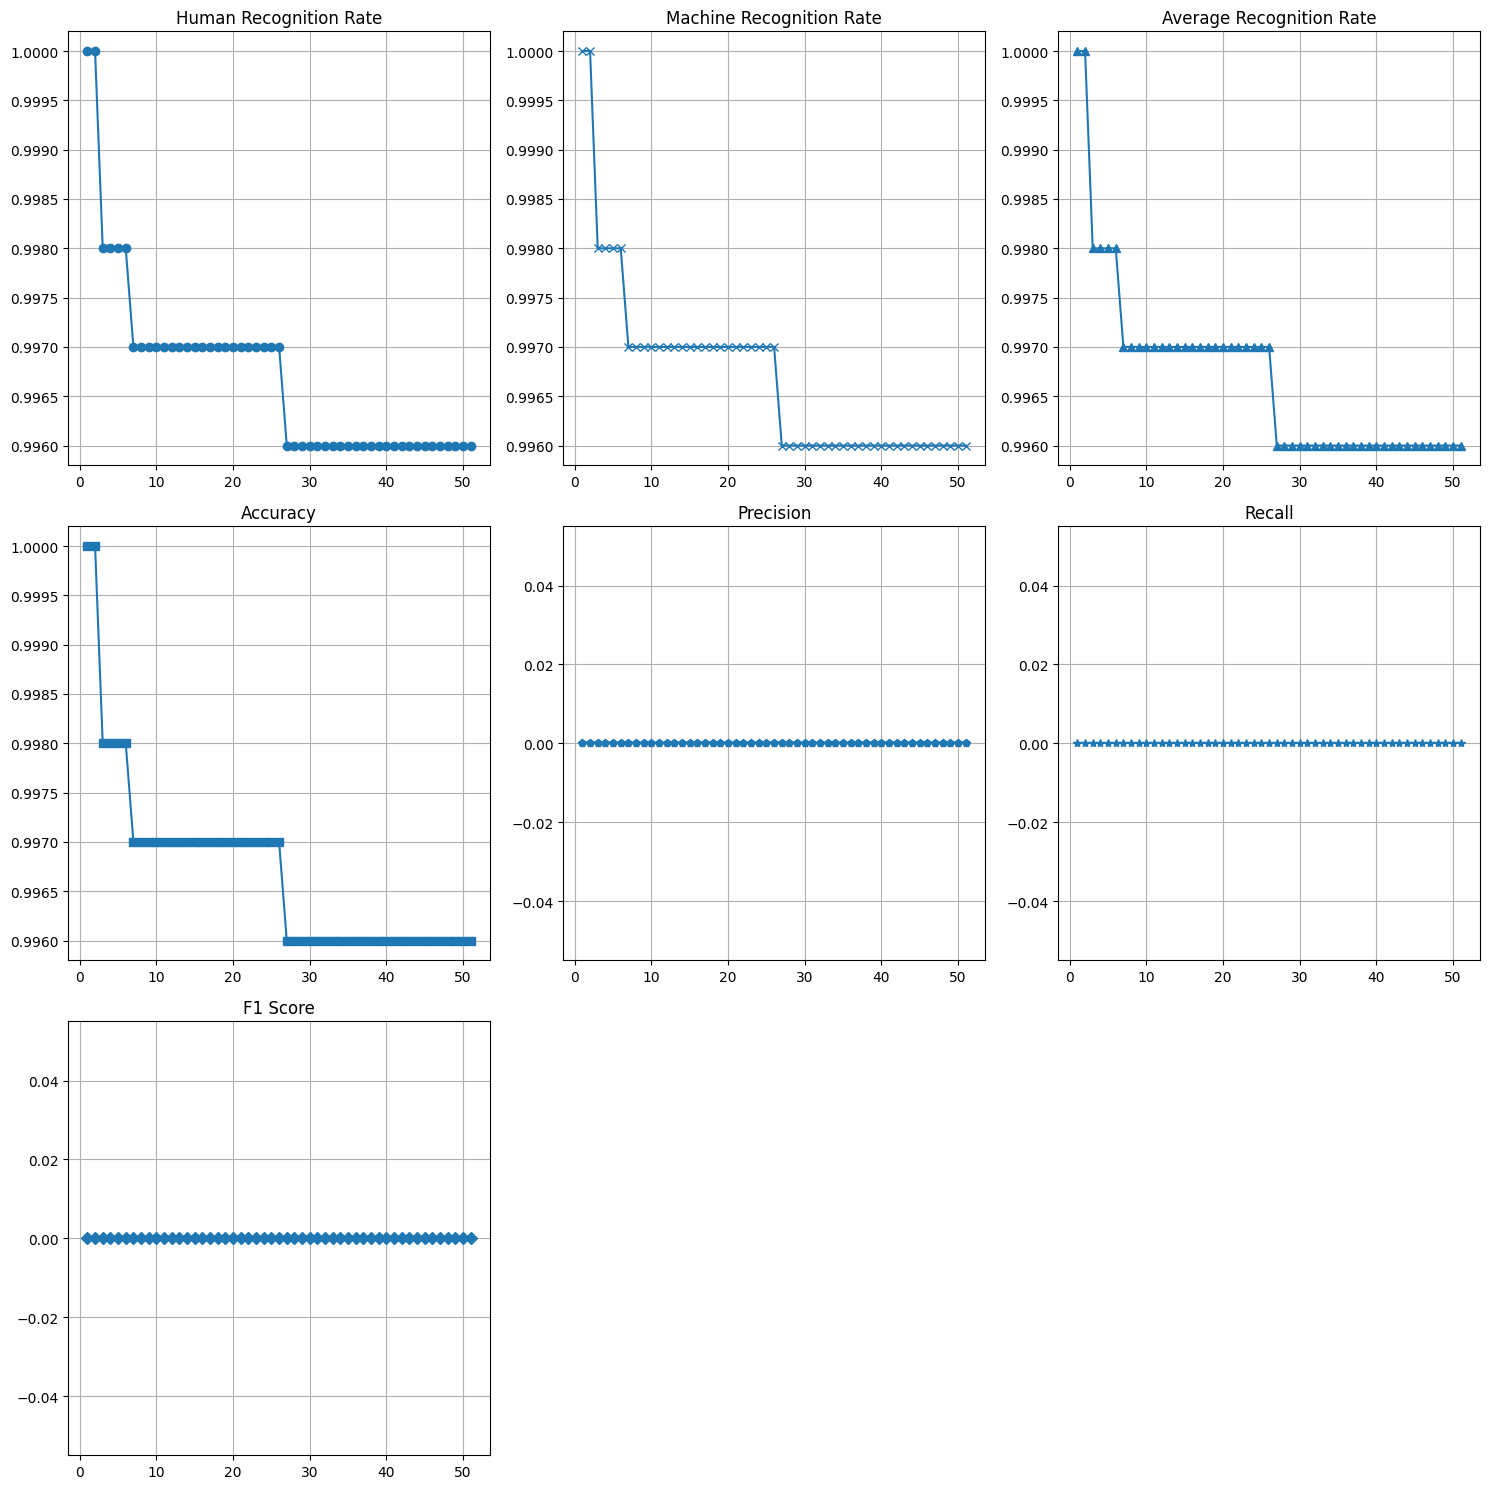

In [5]:
# Import functions from /src files
from src.infer import *
# Import required packages
import argparse
from lightning import Fabric

# Test function with parameters
def test(opt):
    opt.device_num = 1      # The number of devices to use
    opt.batch_size = 128    # Batch size for data loading
    opt.num_workers = 2     # Number of workers for data loading
    opt.embedding_dim = 768 # Dimension of the embeddings
    opt.database_path = "database"            # Path to the database
    opt.mode = 'OUTFOX'                       # Dataset to use
    opt.test_dataset_path = "/content/OUTFOX" # Path to the test dataset
    opt.test_dataset_name = 'test'            # Name of the test dataset
    opt.attack = "none"     # Attack type, can be "none" or "adversarial"
    opt.model_path = path + "/data/OUTFOX_best.pth"            # Path to the model
    opt.model_name = "princeton-nlp/unsup-simcse-roberta-base" # Name of the model
    opt.max_K = 51          # Maximum number of neighbors to consider
    opt.pooling = "average" # Pooling method for embeddings, can be "average" or "max"
    opt.seed = 0            # Random seed for reproducibility
    fabric = Fabric(accelerator="cuda", devices=opt.device_num) # Initialize Fabric
    # Launch the function and its arguments
    fabric.launch(main_inference, opt)

parser = argparse.ArgumentParser()
opt = parser.parse_args([])
test(opt)

The `DeTecTive` model shows a promising approach in identifying AI-generated dataset with an accuracy at above 99.5% across all number of $k$s. Note that the `OUTFOX` dataset is small and only consists of two class: `ChatGPT` and `human`.

As a result, we also experimented the `DeTecTive` model using the `DeepFake` dataset, which contained a much varied amount of sources, including sources not in the training dataset. However, Google Colab is unable to handle this experiment due to the size of the `DeepFake` dataset and packages required (specifically `faiss-gpu`), we run the `DeTecTive` model in a local machine with an Nvidia GPU.

The setup for this dataset is nearly identical to that of `OUTFOX`. The primary differences lie in the size and scope of the dataset, which make it practically not recommended to run with CPU. Impressively, the model performs just as well on the `DeepFake` dataset, despite being much larger and diverse (with 28 classes) compared to the `OUTFOX` dataset.

![deepfake_output.png](https://github.com/gingkwan/storage/blob/main/deepfake_output.png?raw=true)

---
# Conclusion and Future Direction

This project shows a comprehensive approach for detecting AI-generated texts and identifying them to their corresponding generative models using a multi-task, multi-level contrastive learning framework. By integrating vector embeddings, a $k$-Nearest Neighbor classifier, and Training-Free Incremental Adaptation (TFIA), the system demonstrates strong generalization and adaptability across varied AI-generated content. It addresses limitations in existing approaches by avoiding heavy reliance on discourse parsing or overly restrictive filtering, hence preserving stylistic nuances crucial for accurate attribution.

However, their method has a limited capability to explain or explore which features distinguish human-authored text from AI-generated text. Further, The model was not trained on a large-scale corpus, which may constrain its capacity to generalize stylistic nuances.

Further reserach can be done in the following directions to extend the work and address their limitations:
1.	**Token-level interpretability research:** Investigate sub-model level attribution (e.g., identifying prompt styles or fine-tuned variants) could provide deeper insights into generation patterns by different models.
2.	**Training in larger corpus:** Perform the experiment on a larger corpus could enhance the ability to identify writing styles, thereby improving the model's performance.
3.	**Real-world deployment:** Build a lightweight, real-time inference API or browser plugins for scalable deployment in academic, editorial, or content moderation workflows.

---
# References:

[1]: Kuznetsov, K., Tulchinskii, E., Kushnareva, L., Magai, G., Barannikov, S., Nikolenko, S., & Piontkovskaya, I. (2024). Robust AI-Generated Text Detection by Restricted Embeddings. *arXiv preprint arXiv:2410.08113*. https://doi.org/10.48550/arXiv.2410.08113

[2]: Kim, Z. M., Lee, K. H., Zhu, P., Raheja, V., & Kang, D. (2024). Threads of Subtlety: Detecting Machine-Generated Texts Through Discourse Motifs. *arXiv preprint arXiv:2402.10586*. https://doi.org/10.48550/arXiv.2402.10586

[3]: Guo, X., Zhang, S., He, Y., Zhang, T., Feng, W., Huang, H., & Ma, C. (2024). DeTeCtive: Detecting AI-generated Text via Multi-Level Contrastive Learning. *arXiv preprint arXiv:2410.20964*. https://doi.org/10.48550/arXiv.2410.20964